# 0.0 IMPORTS

In [142]:
import pandas as pd
import inflection
import math
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

## Helper Functions

## Load Data

In [84]:
df_sales_raw = pd.read_csv('Data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('Data/store.csv', low_memory=False)

#unindo as duas tabelas através de um left join utilizando a chave estrangeira Store

df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')


low_memory = False -> Os dados são carregados de uma vez só, caso seja False, os dados são carregados em partes.

In [85]:

df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
724359,395,5,2013-09-20,3414,479,1,0,0,0,a,a,3620.0,2.0,2013.0,0,NaN,NaN,NaN


# 1.0 DESCRIÇÃO DOS DADOS

## 1.1 Rename Columns

In [86]:
df1 = df_raw.copy()

In [87]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

In [88]:
#trocando as colunas para snake_case
snake_case = lambda x: inflection.underscore(x)

cols_new = list(map(snake_case, cols_old))

# rename columns

df1.columns = cols_new

In [89]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Data Dimension

In [90]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 1017209
Number of columns: 18


## 1.3 Data Types

In [91]:
df1['date'] = pd.to_datetime(df1['date'])

In [92]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA's

In [93]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

Existem três maneira de se tratara um NA 
1. Excluir os NA's: Vantagem é uma forma rápida, desvantagem é que estamos jogando os dados fora. Principalmente se o resto das colunas tem um valor importante para o negócio
2. Utilizando algoritímos de ML: substituindo as colunas pelo comportamento da coluna, ou seja, calculo da mediana, média, algoritímo para prever qual o valor que estaria no local.
3. Através do entedimento do negócio: Será que é uma regra ou lógica de negócio definido pelo time de negócios?

## 1.5 Fillout NA

#### 1.5.1 competition_distance: distance in meters to the nearest competitor store

- A partir do entendimento do negócio, assumimos que os valores faltantes nesta coluna são consequências de não haver lojas que realizam competição em distâncias curtas, ou a distância é muito grande que nem é computada no dataset. Por isso, a opção por substituir os NA's desta coluna por uma distância muito maior que a distância máxima do meu dataset parece razoável.

In [94]:
df1['competition_distance'].max()

75860.0

In [95]:
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.00 if math.isnan(x) else x)

#### 1.5.2 competition_open_since_month: gives the approximate year and month of the time the nearest competitor was opened
- competition_open_since_year

- Aqui o valor pode estar nulo pela loja concorrente ter aberto antes da minha loja e eu não ter essa data, ou abriu depois e esquecemos de anotar. Para preencher esse NA levamos em conta etapas do feature engineering em que o tempo é muito importante. A solução é pegar a data da última venda.

In [96]:
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

In [97]:
                       
# promo2_since_week  
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year  
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)
             
          

#### 1.5.3 Promo_interval
- A coluna indica uma promoção continua nas lojas, se o valor é nulo quer dizer que a loja não esta realizando promoção

    

In [98]:
month_map = {1 : 'Jan', 
 2 : 'Feb', 
 3 : 'Mar',
 4 : 'Apr',
 5 : 'May',
 6 : 'Jun',
 7 : 'Jul',
 8 : 'Aug',
 9 : 'Sept',
 10 : 'Oct',
 11 : 'Nov',
 12 : 'Dec'}

In [99]:
df1['promo_interval'].fillna(0, inplace=True)    

In [100]:
df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x : 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'] else 0, axis=1)

In [101]:
df1.sample(5).T

,979450,144704,705424,841736,439195
store,151,870,415,697,671
day_of_week,7,2,1,5,2
date,2013-02-03 00:00:00,2015-03-24 00:00:00,2013-10-07 00:00:00,2013-06-07 00:00:00,2014-06-03 00:00:00
sales,0,6731,7308,11698,7639
customers,0,864,609,1073,704
open,0,1,1,1,1
promo,0,0,1,1,1
state_holiday,0,0,0,0,0
school_holiday,0,0,1,0,0
store_type,d,a,d,d,a


In [102]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Data Types

In [103]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [104]:
df1['competition_open_since_month']= df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year']= df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [105]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Descriptive Statiscal

Antes de calcular a estatística descritiva devo separar meus dados em numéricos e categóricos

### 1.7.1 Numerical Attributes

In [107]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])

cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

In [126]:
#Central tendence - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, Kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply( min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

m = pd.concat([d2,d3,d4,ct1, ct2, d1,d5, d6]).T.reset_index()

m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']



In [127]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


/tmp/ipykernel_167571/710812770.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1['sales'])


<Axes: xlabel='sales', ylabel='Density'>

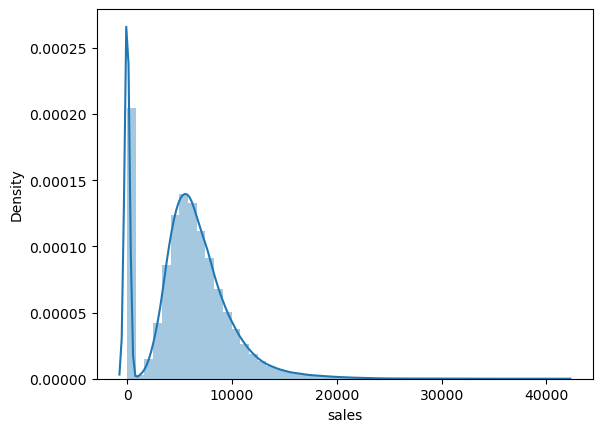

In [128]:
sns.distplot(df1['sales'])

### 1.7.2 Categorical Attributes

In [135]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

In [137]:
df1['state_holiday'].unique()

array(['0', 'a', 'b', 'c'], dtype=object)

<Axes: xlabel='assortment', ylabel='sales'>

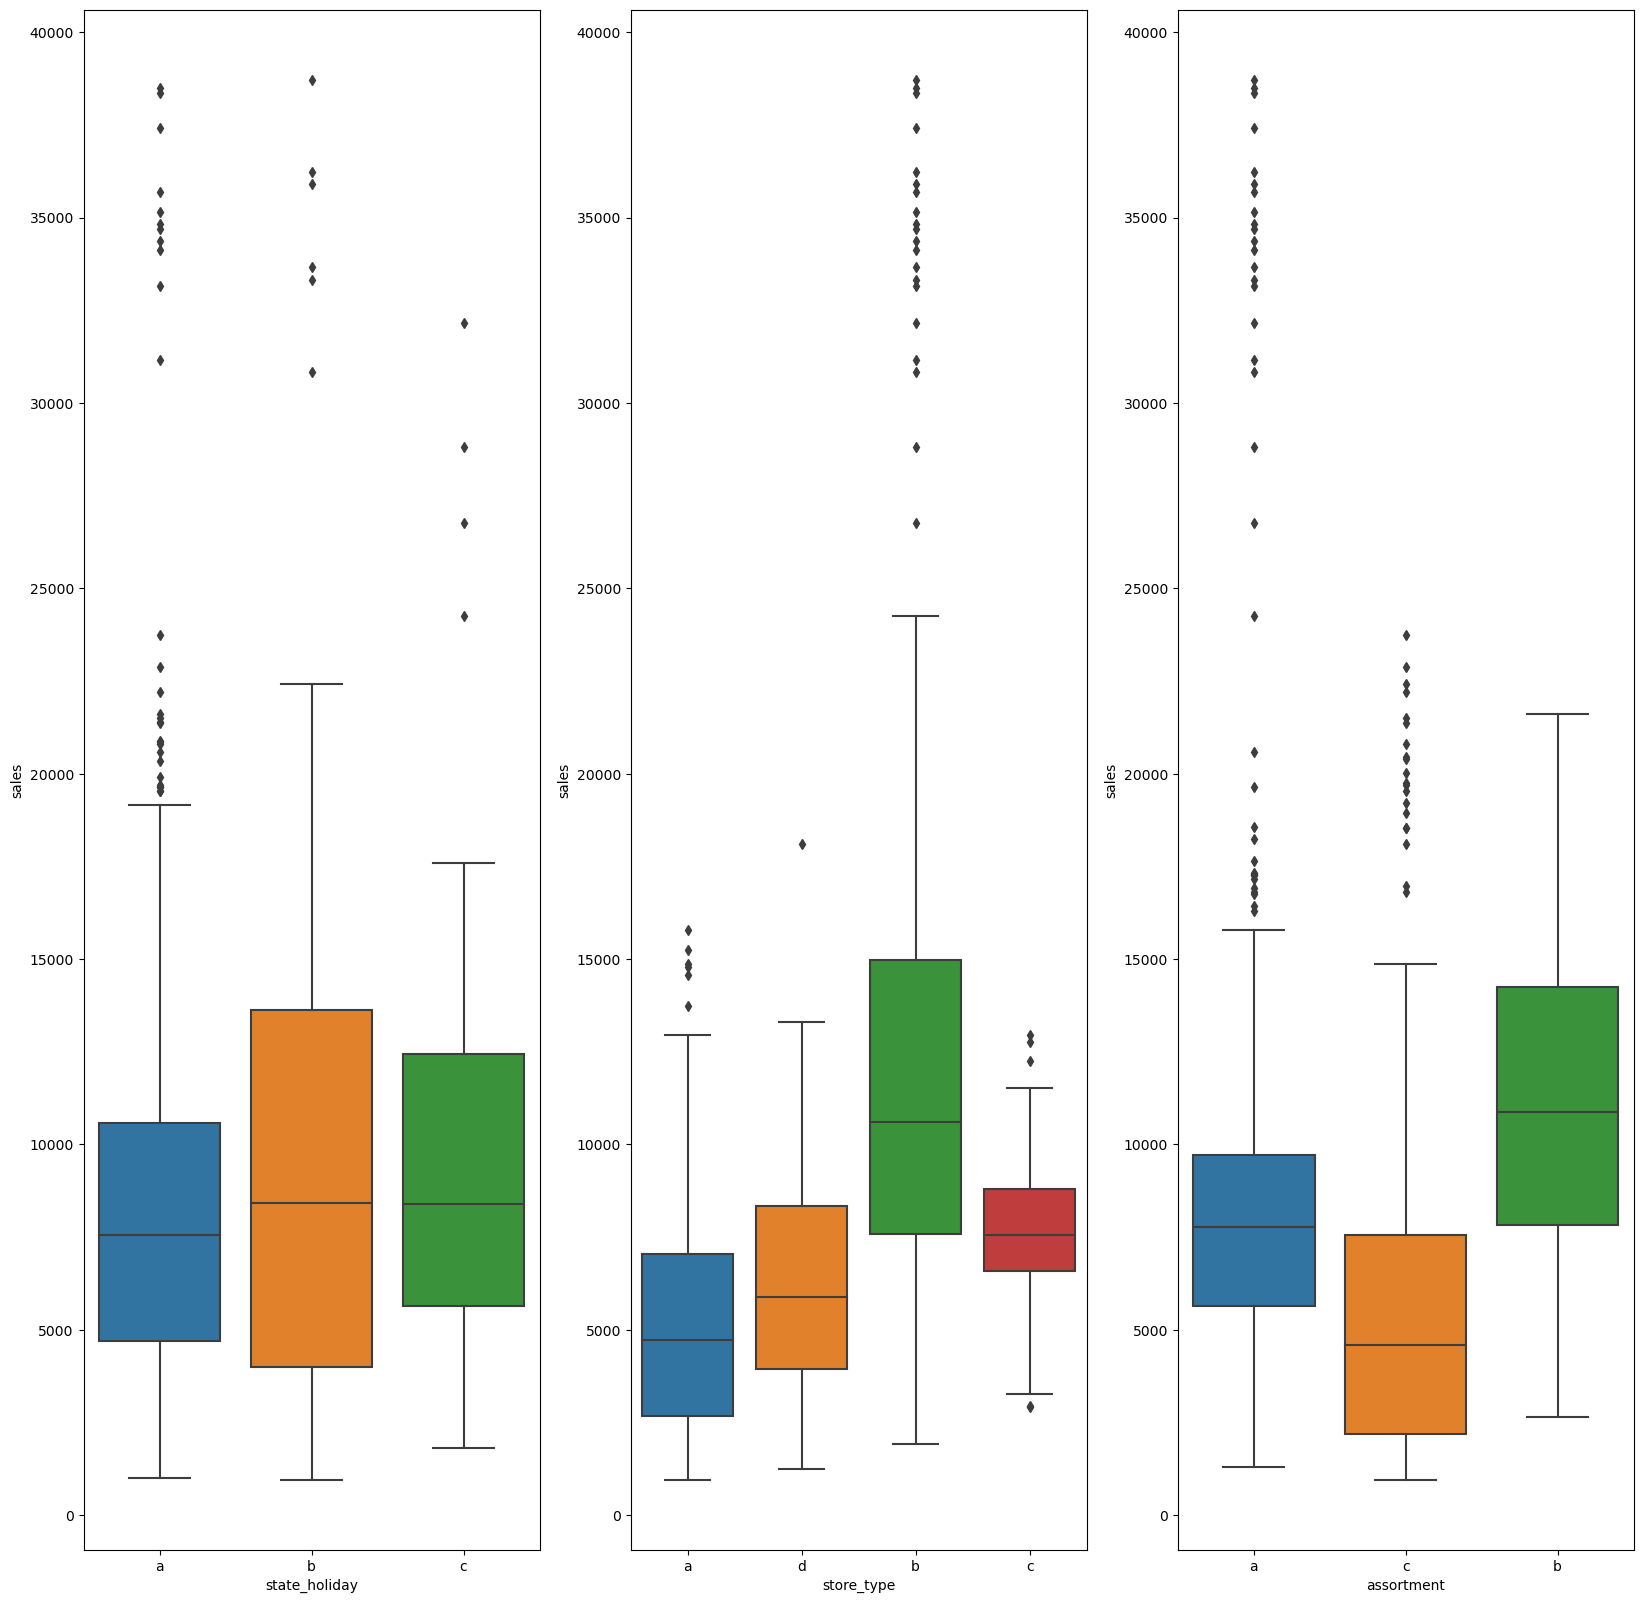

In [146]:
aux = df1[(df1['sales'] > 0 ) & (df1['state_holiday'] != '0')]

plt.figure(figsize=(20,20))
plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales', data=aux)

plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales', data=aux)

plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales', data=aux)



## 1.8